# Package Tutorial: reddit_ideology

## Step 1: Install Package

In [2]:
#%pip install -e ..

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Step 2: Load Package & config.yaml

In [ ]:
import sys, os
import numpy as np
import pandas as pd

PROJECT_ROOT = os.path.abspath(os.path.join(".."))    # from scripts/ up to css_package/
SRC_PATH     = os.path.join(PROJECT_ROOT, "src")      # …/css_package/src
print("Adding to sys.path:", SRC_PATH)
if SRC_PATH not in sys.path:
    sys.path.insert(0, SRC_PATH)

print("sys.path now contains:")
for p in sys.path[:5]:
    print("  ", p)

from reddit_ideology import (
    load_config,
    DataLoader,
    Preprocessor,
    EmbeddingModel,
    TopicModel,
    MetricsCalculator,
    Visualizer
)

config = load_config("config.yaml")
config

## Step 3: Load in Data

In [7]:
dl = DataLoader(
    config['data']['conservative_path'],
    config['data']['liberal_path']
)
cons_df, lib_df = dl.load()

cons_df.head()

,timestamp,text,subreddit
0,2011-05-03 14:01:23,We’re still seeing a flood of calls from both ...,conservative
1,2011-05-04 16:08:36,In a story about the resurrection of the harsh...,conservative
2,2011-05-05 06:52:52,Political Byline This blog is no longer active...,conservative
3,2011-05-05 11:04:22,Our results underscore the decisive relevance ...,conservative
4,2011-05-05 15:45:56,by Martin and Marcia The most recent double is...,conservative


## Step 4: Preprocess Data

In [8]:
pp = Preprocessor()
cons_df = pp.apply(cons_df)
lib_df = pp.apply(lib_df)

cons_df[['text','clean_text']].head()

,text,clean_text
0,We’re still seeing a flood of calls from both ...,were still seeing a flood of calls from both s...
1,In a story about the resurrection of the harsh...,in a story about the resurrection of the harsh...
2,Political Byline This blog is no longer active...,political byline this blog is no longer active...
3,Our results underscore the decisive relevance ...,our results underscore the decisive relevance ...
4,by Martin and Marcia The most recent double is...,by martin and marcia the most recent double is...


## Step 5: Generate Embeddings

In [9]:
emb_cfg = config['embedding']
embedder = EmbeddingModel(
    model_name=emb_cfg['model_name'],
    batch_size=emb_cfg['batch_size'],
    device=emb_cfg['device'],
    cache_dir=config['output']['cache_dir']
)
cons_emb = embedder.embed(cons_df['clean_text'].tolist(), name="conservative")
lib_emb = embedder.embed(lib_df['clean_text'].tolist(), name="liberal")

print("Shapes:", cons_emb.shape, lib_emb.shape)

Embedding liberal: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [04:34<00:00,  3.15s/it]


Shapes: (22128, 768) (22153, 768)


## Step 6: Topic Modeling via Clustering

In [10]:
tm_cfg = config['topic_model']['cluster']
topic_model = TopicModel(
    umap_neighbors=tm_cfg['umap_neighbors'],
    umap_min_dist=tm_cfg['umap_min_dist'],
    hdbscan_min_cluster_size=tm_cfg['hdbscan_min_cluster_size'],
    cache_dir=config['output']['cache_dir']
)
cons_topics = topic_model.fit(cons_emb, name="conservative")
lib_topics = topic_model.fit(lib_emb, name="liberal")

print("Conservative topics:", np.unique(cons_topics))
print("Liberal topics:", np.unique(lib_topics))

/home/isaacharlem/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/isaacharlem/.conda/envs/red_id/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)
/home/isaacharlem/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/isaacharlem/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/isaacharlem/.local/lib/python3.10/site-packages/sk

Conservative topics: [ -1   0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16
  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34
  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52
  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70
  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88
  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106
 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124
 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142
 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160
 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178
 179]
Liberal topics: [ -1   0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16
  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34
  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52
  53  54

## Step 7: Compute Metrics

In [18]:
from collections import Counter
from reddit_ideology.openai_utils import init_openai, generate_topic_label
from reddit_ideology.topic_model import EmbeddingClusterTopicModel
from reddit_ideology.metrics import MetricsCalculator

client = init_openai(config['openai']['api_key'])

In [19]:
# === 2) Extract top terms & label topics ===
def extract_top_terms(df, topics, top_n):
    counts = {}
    for tid in sorted(set(topics)):
        texts = df.loc[topics == tid, 'clean_text']
        words = Counter(" ".join(texts).split())
        counts[tid] = [w for w,_ in words.most_common(top_n)]
    return counts

max_terms = config.get('openai', {}).get('max_terms', 10)
# conservative
cons_terms  = extract_top_terms(cons_df, cons_topics, max_terms)
cons_labels = {
    tid: generate_topic_label(client, terms, model=config['openai']['model'])
    for tid, terms in cons_terms.items()
}
# liberal
lib_terms  = extract_top_terms(lib_df, lib_topics, max_terms)
lib_labels = {
    tid: generate_topic_label(client, terms, model=config['openai']['model'])
    for tid, terms in lib_terms.items()
}

# === 3) Compute all metrics ===
mc = MetricsCalculator(config['output']['metrics_dir'])

cons_metrics = mc.topic_entropy_and_count(
    topics=cons_topics,
    timestamps=cons_df['timestamp'],
    freq=config['analysis']['time_interval']
)
lib_metrics = mc.topic_entropy_and_count(
    topics=lib_topics,
    timestamps=lib_df['timestamp'],
    freq=config['analysis']['time_interval']
)

spread_df = mc.semantic_spread(
    embeddings=np.vstack([cons_emb, lib_emb]),
    topics=np.concatenate([cons_topics, lib_topics]),
    timestamps=pd.concat([cons_df['timestamp'], lib_df['timestamp']]),
    freq=config['analysis']['time_interval']
)

intra_cons = mc.intra_group_similarity(
    embeddings=cons_emb,
    timestamps=cons_df['timestamp'],
    freq=config['analysis']['time_interval']
)
intra_lib = mc.intra_group_similarity(
    embeddings=lib_emb,
    timestamps=lib_df['timestamp'],
    freq=config['analysis']['time_interval']
)
cross_sim = mc.cross_group_similarity(
    emb1=cons_emb, emb2=lib_emb,
    ts1=cons_df['timestamp'], ts2=lib_df['timestamp'],
    freq=config['analysis']['time_interval']
)

# === 4) Quick check ===
print("Conservative topic labels:", cons_labels)
print("Liberal topic labels:     ", lib_labels)
cons_metrics.head()

Conservative topic labels: {-1: 'General Political Discourse', 0: 'Election Results', 1: 'Error Message', 2: 'General Political Discourse', 3: 'Email Moderation', 4: 'General Political Discourse', 5: 'IRS Policy', 6: 'General Political Discourse', 7: 'General Political Discourse', 8: 'General Political Discourse', 9: 'General Political Discourse', 10: 'General Political Discourse', 11: 'Ebola Policy', 12: 'North Korea', 13: 'China Relations', 14: 'General Political Discourse', 15: 'General Political Discourse', 16: 'Trade Policy', 17: 'Trade Policy', 18: 'General Political Discourse', 19: 'General Political Discourse', 20: 'China Relations', 21: 'General Political Discourse', 22: 'General Political Discourse', 23: 'General Political Discourse', 24: 'General Political Discourse', 25: 'General Political Discourse', 26: 'Google Politics', 27: 'General Political Discourse', 28: 'Marijuana Legislation', 29: 'Virginia Politics', 30: 'General Political Discourse', 31: 'General Political Disco

,period,entropy,topic_count
0,2011-01-01,3.084234,96
1,2012-01-01,3.200111,122
2,2013-01-01,3.343434,133
3,2014-01-01,3.379819,125
4,2015-01-01,3.514009,157


## Step 8: Visualize Results

Q1: Entropy trend p-values => conservative=0.986, liberal=0.458
Q3: Intra-group similarity difference p-value = 0.00715


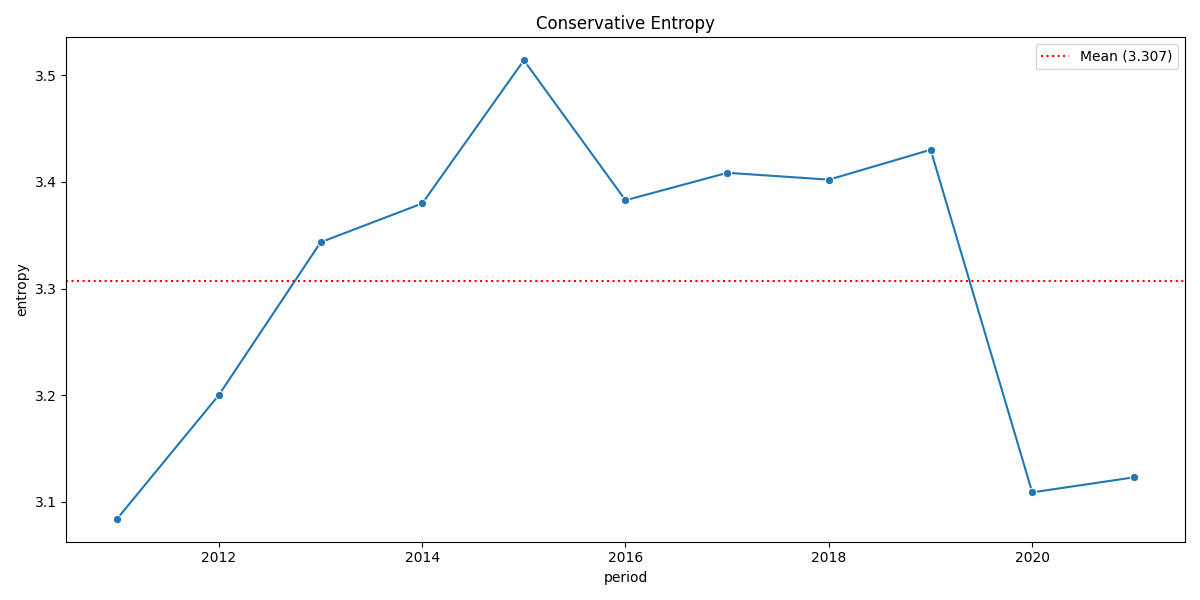

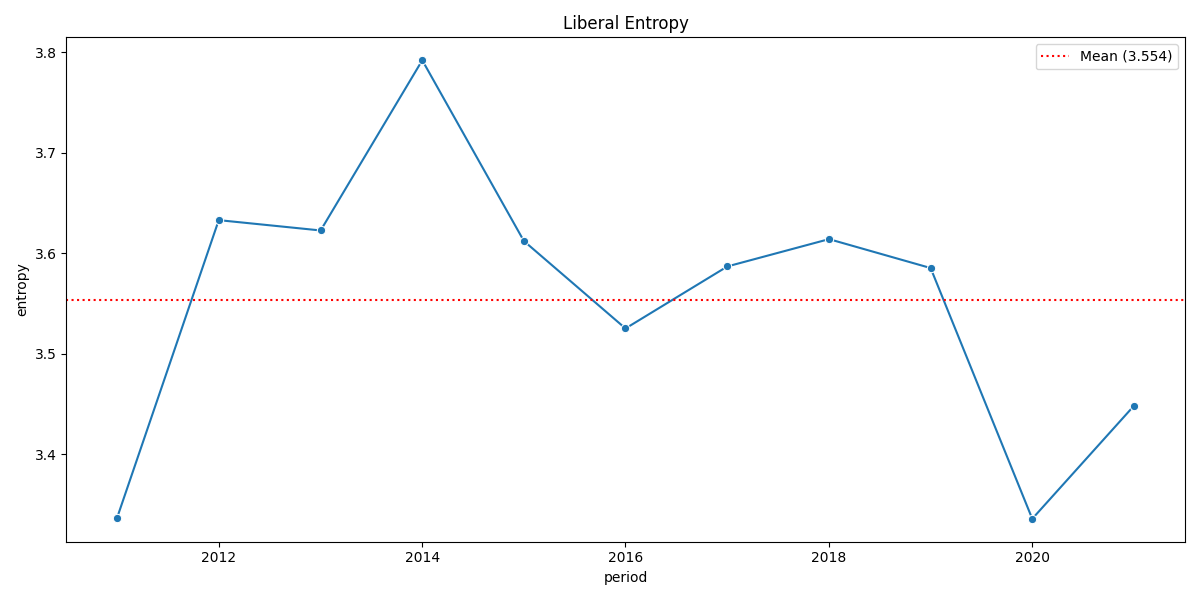

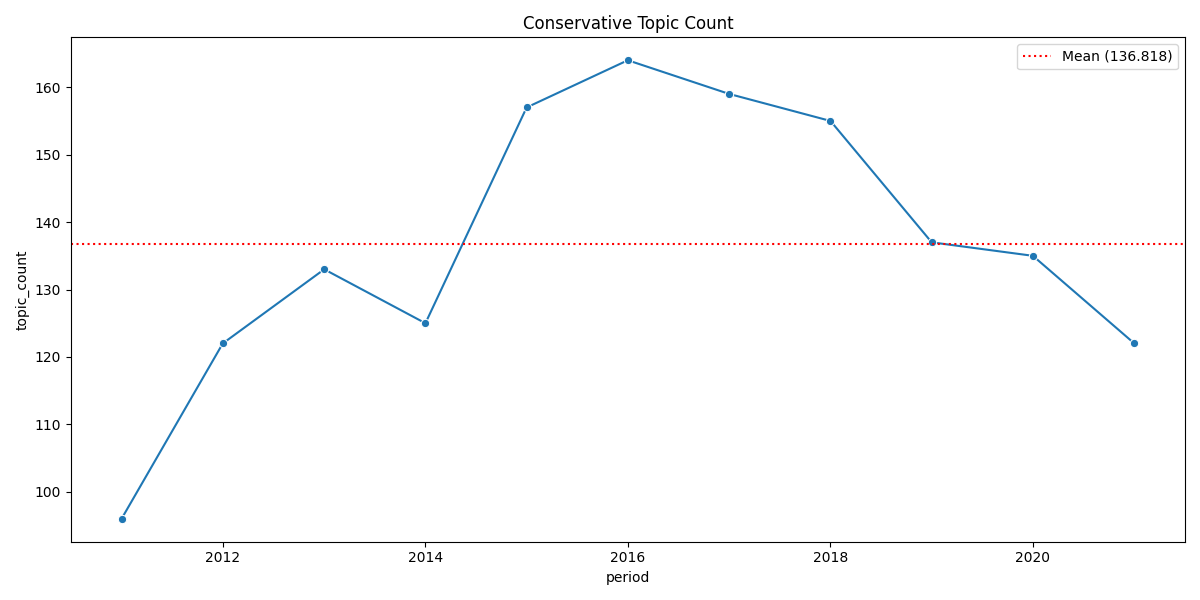

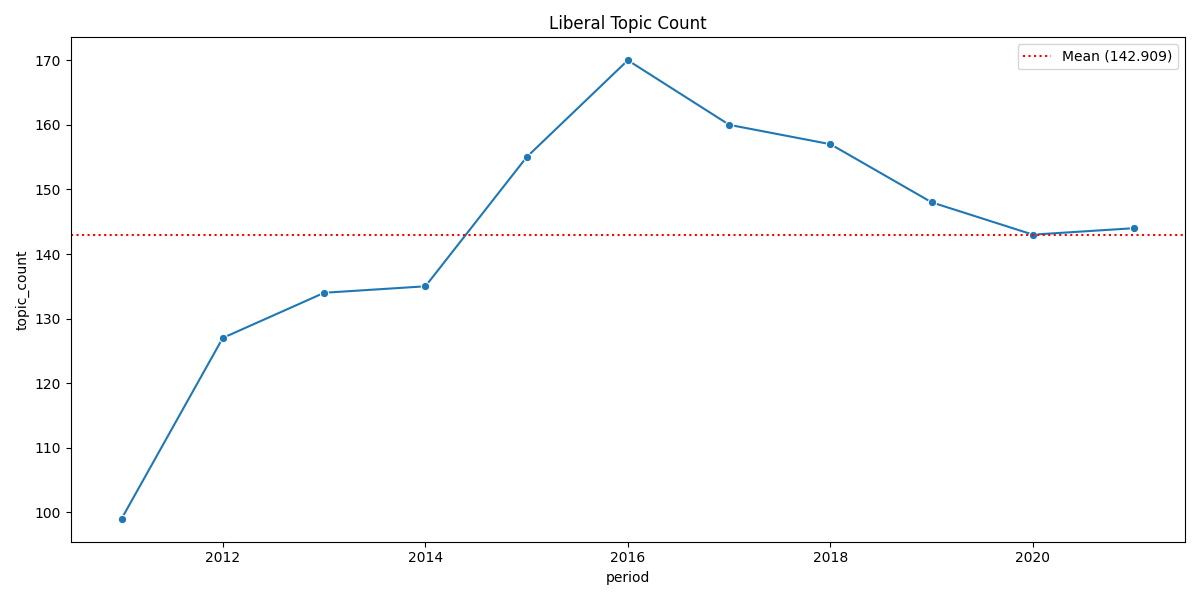

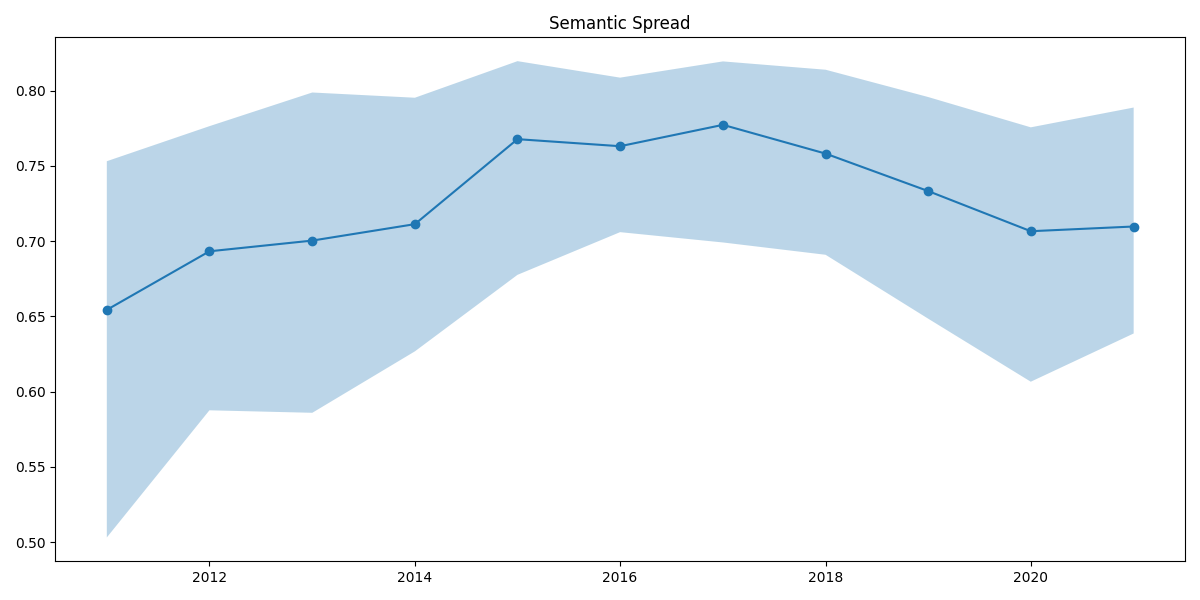

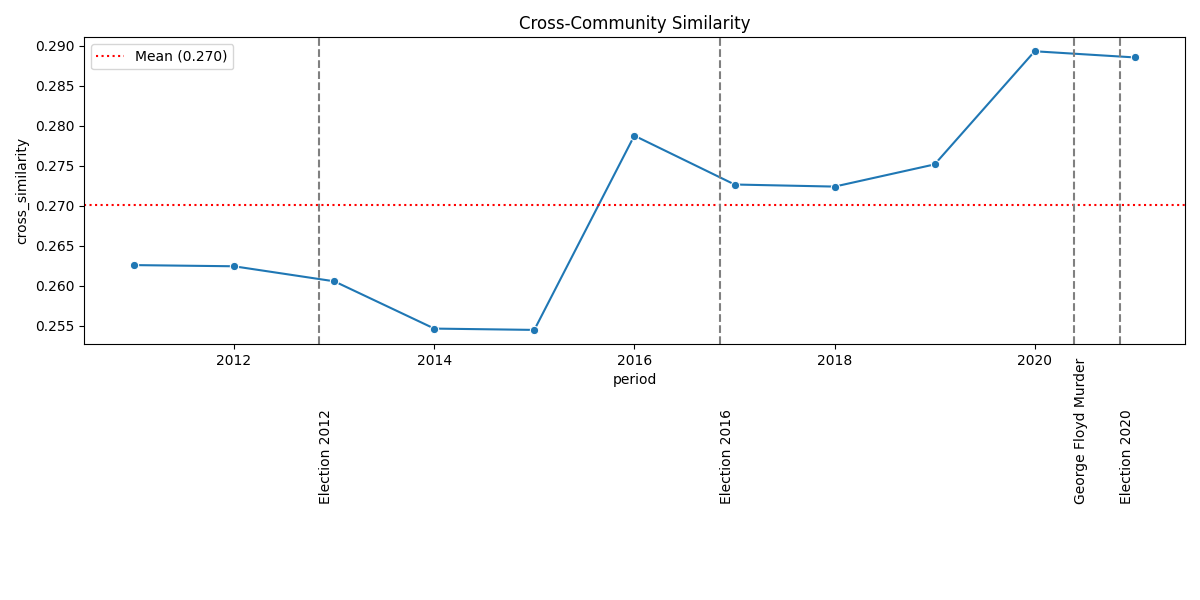

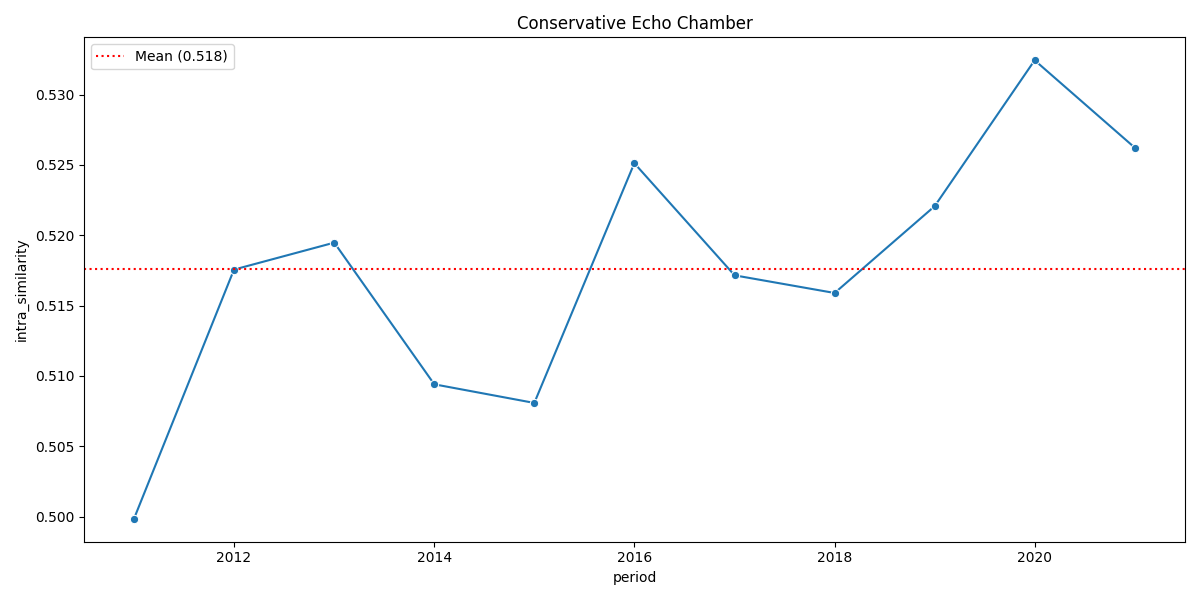

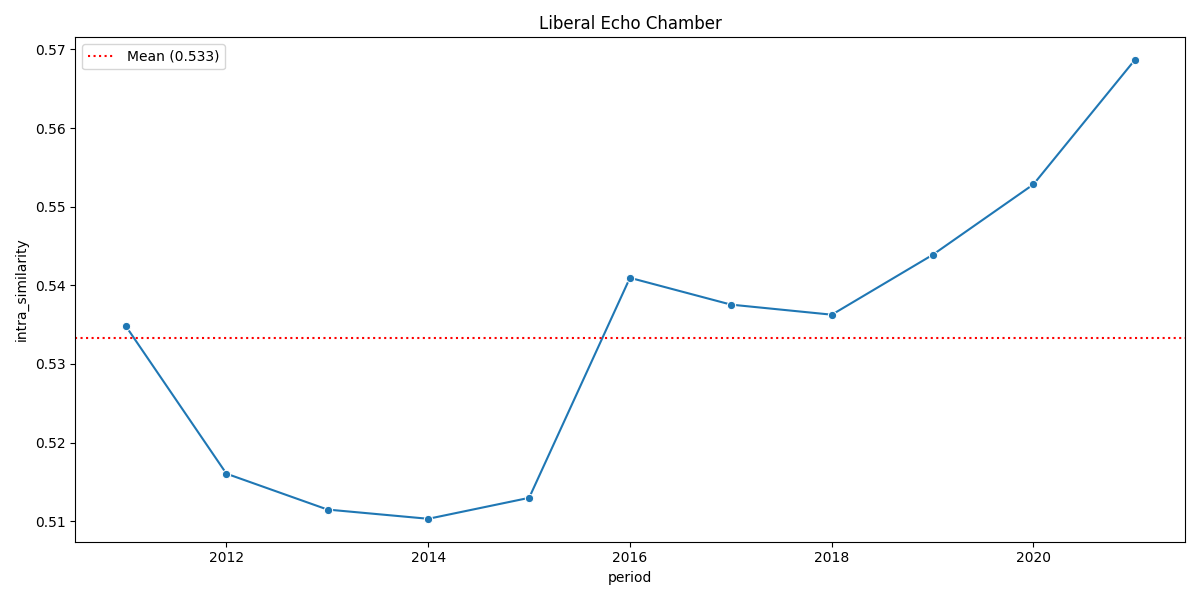

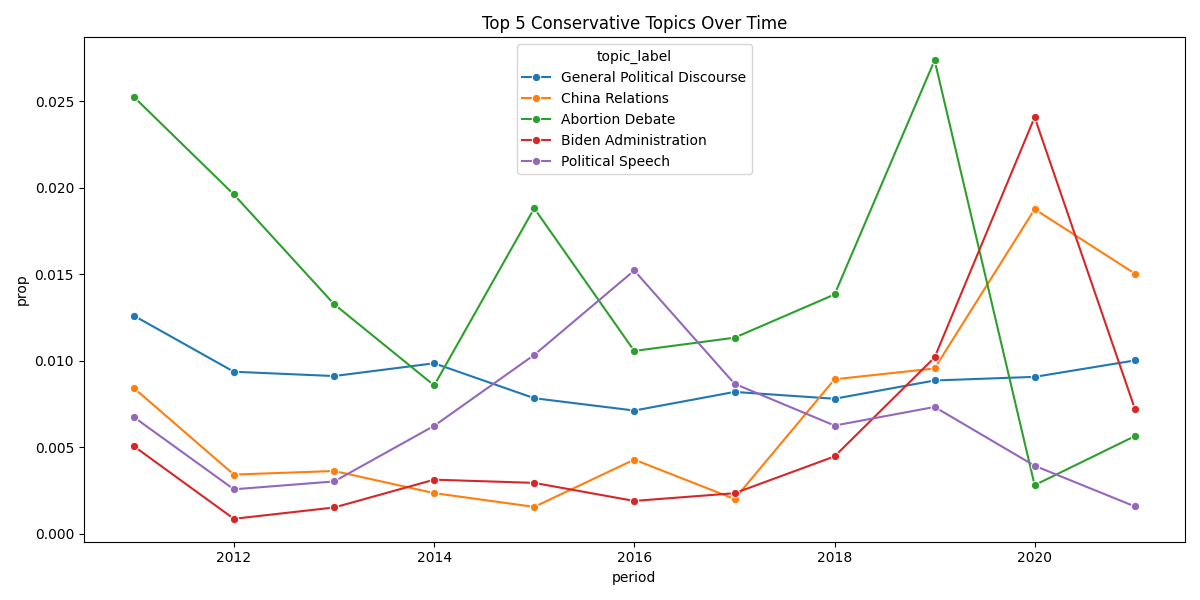

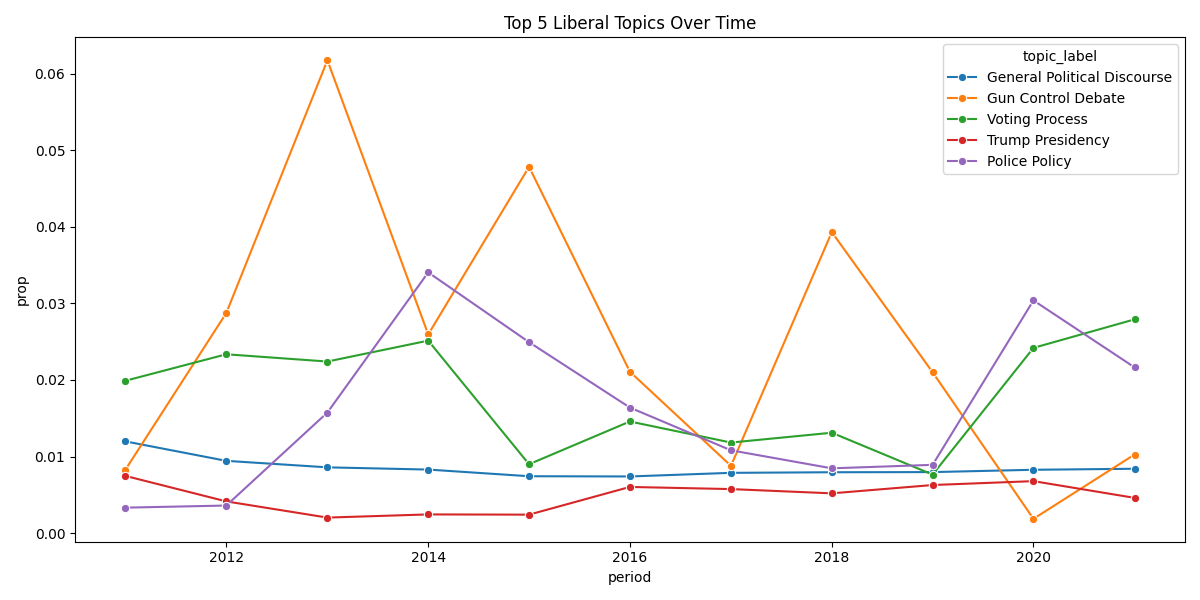

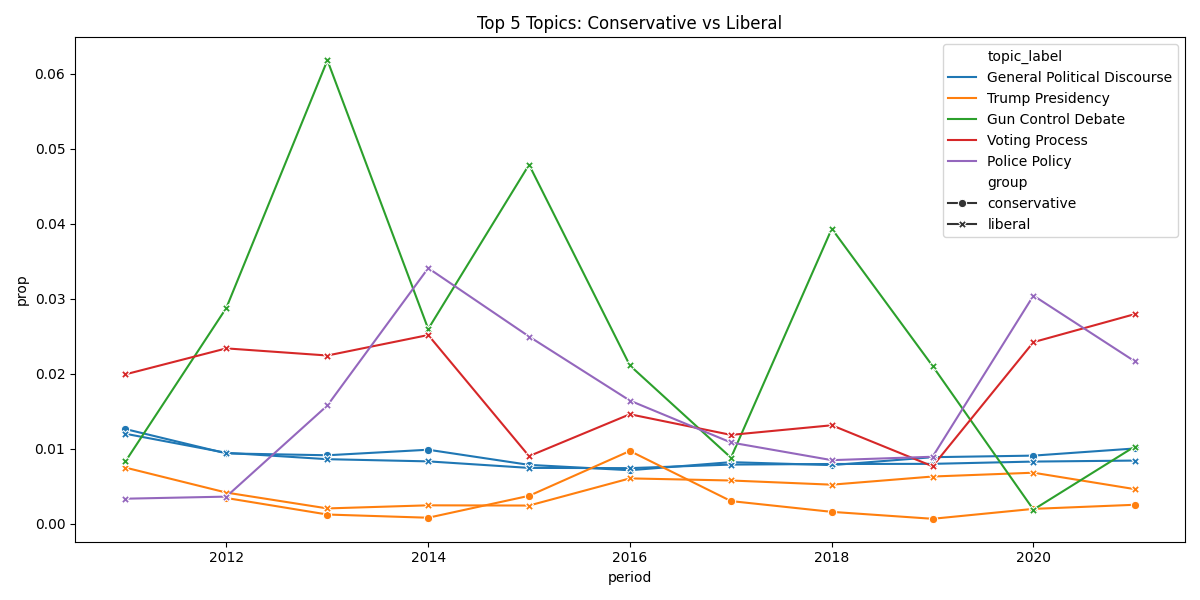

In [20]:
import pandas as pd
import scipy.stats as stats
from IPython.display import Image, display
from reddit_ideology.config import load_config
from reddit_ideology.visualize import Visualizer

# Load config & parse events
cfg = load_config('config.yaml')
outdir = cfg['output']['plots_dir']
prepost = cfg.get('stats', {}).get('prepost_window', 3)
events = [{'name': ev['name'], 'date': pd.to_datetime(ev['date'])} for ev in cfg.get('events', [])]

# Statistical tests & p-values
years_con = cons_metrics['period'].dt.year.astype(int)
p_ent_con = stats.linregress(years_con, cons_metrics['entropy']).pvalue
years_lib = lib_metrics['period'].dt.year.astype(int)
p_ent_lib = stats.linregress(years_lib, lib_metrics['entropy']).pvalue
print(f"Q1: Entropy trend p-values => conservative={p_ent_con:.3g}, liberal={p_ent_lib:.3g}")

for ev in events:
    before = cross_sim[
        (cross_sim['period'] >= ev['date'] - pd.DateOffset(months=prepost)) &
        (cross_sim['period'] < ev['date'])
    ]['cross_similarity']
    after = cross_sim[
        (cross_sim['period'] > ev['date']) &
        (cross_sim['period'] <= ev['date'] + pd.DateOffset(months=prepost))
    ]['cross_similarity']
    if len(before) and len(after):
        p = stats.ttest_ind(before, after, equal_var=False).pvalue
        print(f"Q2 ({ev['name']}): cross-sim p-value = {p:.3g}")

merged = pd.merge(
    intra_cons.rename(columns={'intra_similarity':'con'}),
    intra_lib.rename(columns={'intra_similarity':'lib'}),
    on='period'
)
p_echo = stats.ttest_rel(merged['con'], merged['lib']).pvalue
print(f"Q3: Intra-group similarity difference p-value = {p_echo:.3g}")

# Visualizations
viz = Visualizer(outdir)
viz.plot_time_series(cons_metrics, 'period', 'entropy', title='Conservative Entropy', filename='cons_entropy.png')
viz.plot_time_series(lib_metrics, 'period', 'entropy', title='Liberal Entropy', filename='lib_entropy.png')
viz.plot_time_series(cons_metrics, 'period', 'topic_count', title='Conservative Topic Count', filename='cons_topic_count.png')
viz.plot_time_series(lib_metrics, 'period', 'topic_count', title='Liberal Topic Count', filename='lib_topic_count.png')

ribbon = spread_df.groupby('period')['spread'].agg(
    median='median',
    q1=lambda x: x.quantile(0.25),
    q3=lambda x: x.quantile(0.75)
).reset_index()
viz.plot_ribbon(ribbon, 'period', 'median', 'q1', 'q3', title='Semantic Spread', filename='semantic_spread.png')

viz.plot_time_series(cross_sim, 'period', 'cross_similarity', title='Cross-Community Similarity', events=events, filename='cross_similarity.png')
viz.plot_time_series(intra_cons, 'period', 'intra_similarity', title='Conservative Echo Chamber', filename='intra_cons.png')
viz.plot_time_series(intra_lib, 'period', 'intra_similarity', title='Liberal Echo Chamber', filename='intra_lib.png')

def freq_df(df, topics):
    return (
        pd.DataFrame({'timestamp': df['timestamp'], 'topic': topics})
        .assign(
            period=lambda d: d['timestamp']
                               .dt.to_period(cfg['analysis']['time_interval'])
                               .dt.to_timestamp()
        )
        .groupby(['period','topic'])
        .size()
        .reset_index(name='count')
    )

cons_freq = freq_df(cons_df, cons_topics)
lib_freq = freq_df(lib_df, lib_topics)
cons_freq['topic_label'] = cons_freq['topic'].map(cons_labels)
lib_freq['topic_label'] = lib_freq['topic'].map(lib_labels)

top_n = cfg.get('analysis', {}).get('top_n', 5)
viz.plot_topic_prevalence(cons_freq, period_col='period', topic_col='topic_label', count_col='count',
                          top_n=top_n, normalize=True,
                          title=f'Top {top_n} Conservative Topics Over Time',
                          filename=f'cons_top{top_n}_topics.png')
viz.plot_topic_prevalence(lib_freq, period_col='period', topic_col='topic_label', count_col='count',
                          top_n=top_n, normalize=True,
                          title=f'Top {top_n} Liberal Topics Over Time',
                          filename=f'lib_top{top_n}_topics.png')
viz.plot_combined_topic_trends(cons_freq, lib_freq, period_col='period', topic_col='topic_label',
                               count_col='count', top_n=top_n, normalize=True,
                               title=f'Top {top_n} Topics: Conservative vs Liberal',
                               filename=f'combined_top{top_n}_topics.png')

# Display all PNGs
for fn in [
    'cons_entropy.png', 'lib_entropy.png',
    'cons_topic_count.png', 'lib_topic_count.png',
    'semantic_spread.png', 'cross_similarity.png',
    'intra_cons.png', 'intra_lib.png',
    f'cons_top{top_n}_topics.png',
    f'lib_top{top_n}_topics.png',
    f'combined_top{top_n}_topics.png'
]:
    display(Image(f"{outdir}/{fn}"))
